Exploring the output files generated by the Salish Sea Atlantis Model
to try to reeduce PAH build-up in the biopools.

Test scenarios
1. reduce contam decay timestep to bm -> dt (changed time_step to bm->dt for all contam species decay atContaminants.c line 1077)
1. changed the PAH half_life from being denominated in seconds -> days
1. removed division by time_step atContaminants.c line 1092: bm->contaminantStructure[cIndex]->sp_amount_decayed[sp][cohort] = (cGroupLevel - newValue);
1. removed division by time_step (/dtsz) atContaminants.c line 953: transfer = cGroupLevel * propEaten

With fprints
1. 575 Phytop Calling Group_Transfer_Contaminant + 2238 Carrion Calling Group_Transfer_Contaminant
1. same as above + all group transfers (Group_Transfer_Contaminant from group, to group, dtsz)
1. fprint atContaminants.c line 1039 end of Group_Transfer_Contaminant, from group PL, to group, propContam, contam tranferred, biomass transfered --> seg fault (twice)
1. fprint atContaminants.c line 1213 flag_contamMortModel "Time: %e %s-%d contaminantSpMor: %e\n"
1. to run atContaminants.c line 913  if(FunctGroupArray[fromGuild].groupType == LG_PHY){}

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [3]:
test0_file =  "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_0_withfprints/outputSalishSea.nc"
test1_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_bmdt2/outputSalishSea.nc"
test3_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_3/outputSalishSea.nc"
test4_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_4/outputSalishSea.nc"

test0 = xr.open_dataset(str(test0_file), decode_cf=True)
test1 = xr.open_dataset(str(test1_file), decode_cf=True)
test3 = xr.open_dataset(str(test3_file), decode_cf=True)
test4 = xr.open_dataset(str(test3_file), decode_cf=True)
time = np.ma.filled(test0.variables['t'], np.nan)

Check for contaminant injection

In [4]:
# scenarios = [test1, test3]
# names = ['bm->dt', 'no time_step division']

scenarios = [test0, test4]
names = ['no change','modified line 953']

In [5]:
def plot_pah(scenario, times):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        contam = np.ma.filled(scenario.variables[pah], np.nan)
        contam = contam.sum(axis=2)
        contam = contam.sum(axis=1)

        ax.plot(times, contam)
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH m$^{-3}$');

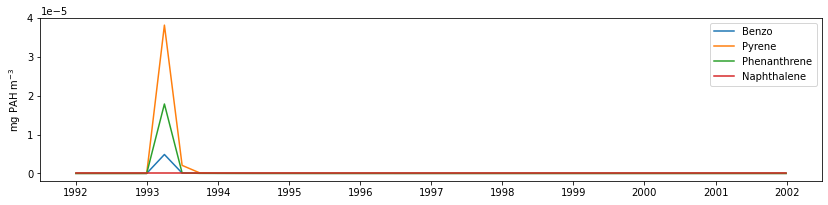

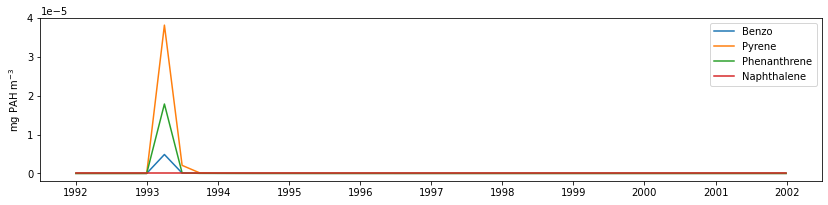

In [6]:
for scenario in scenarios:
    plot_pah(scenario, time)

In [7]:
def tissue_concentration(group, pah, scens, names=names):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time, pelagic_oiled, linewidth = 2) #semilogy
        
        plt.ylabel('mg '+str(pah), fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

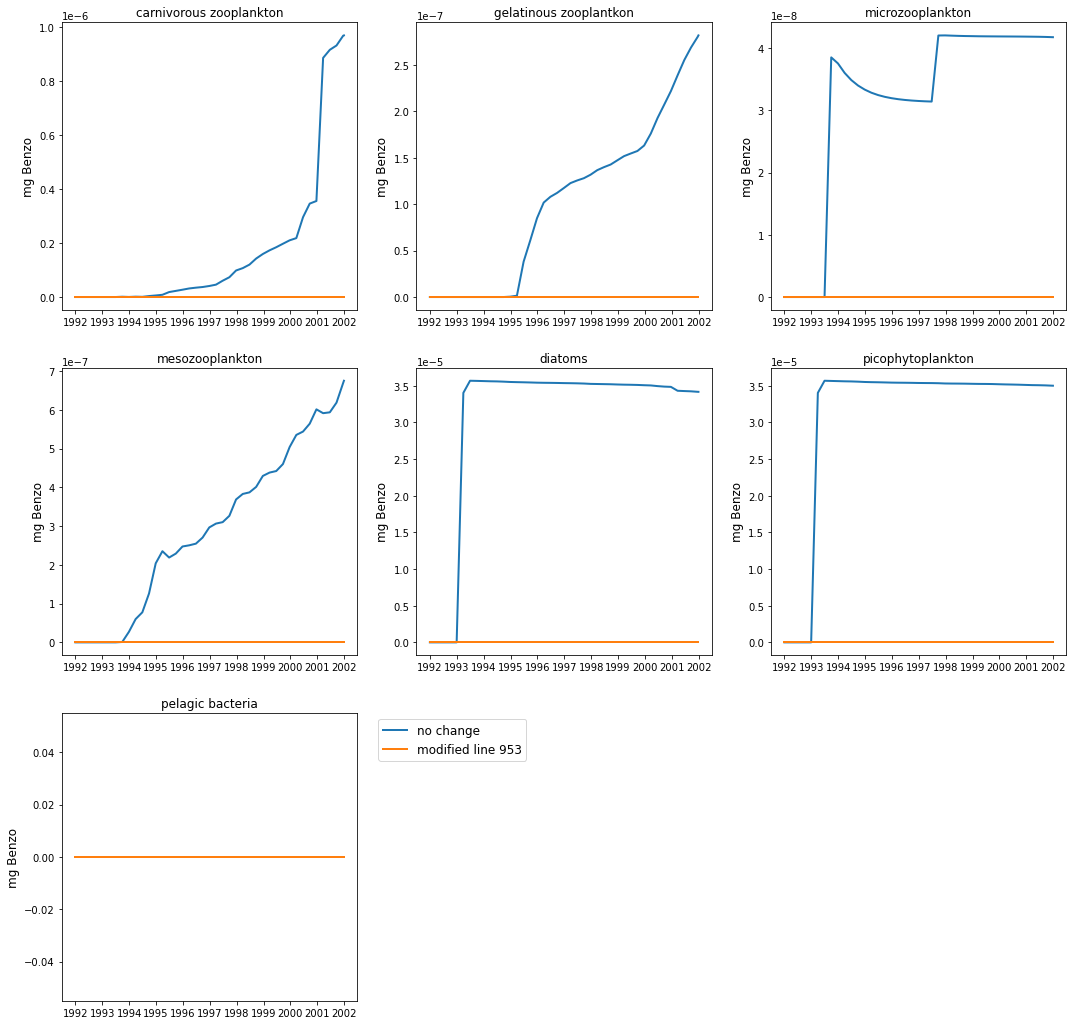

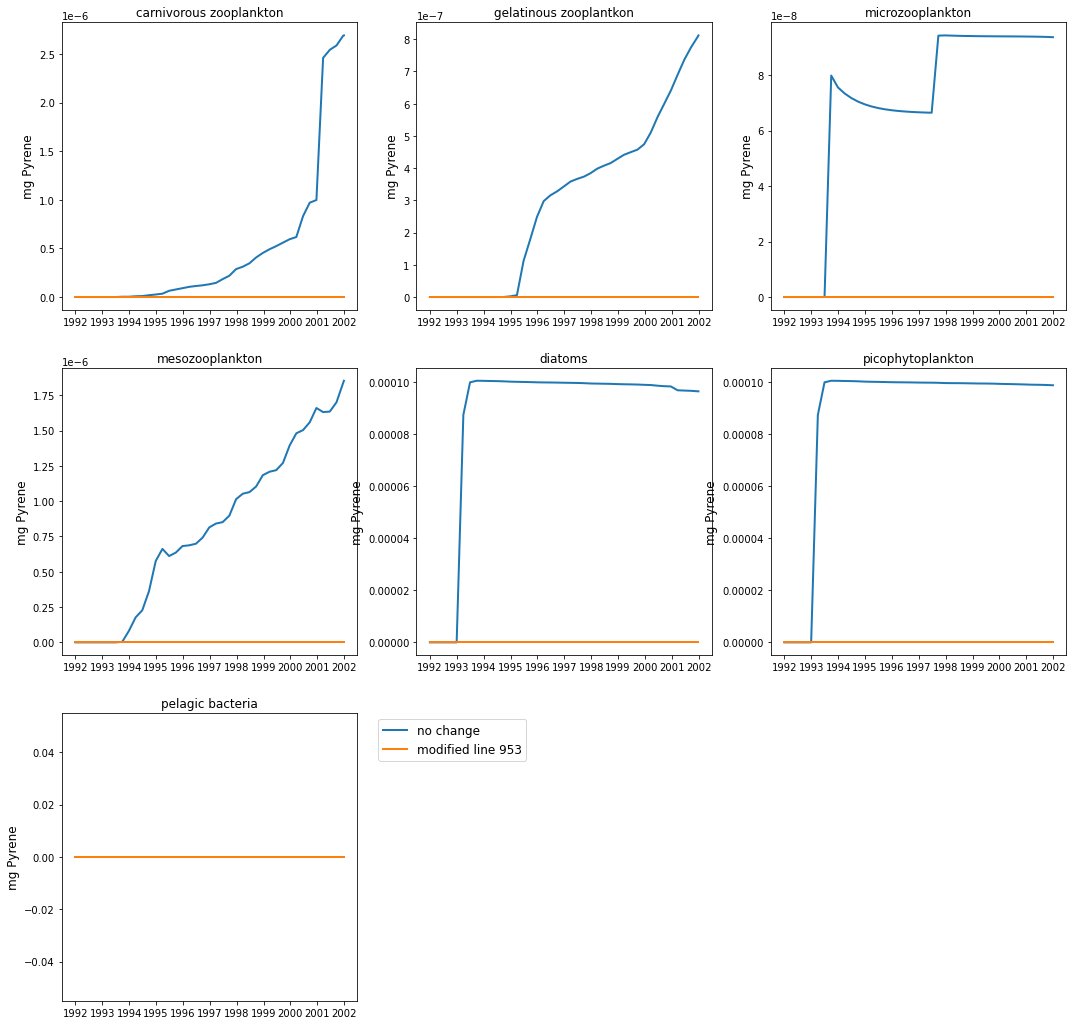

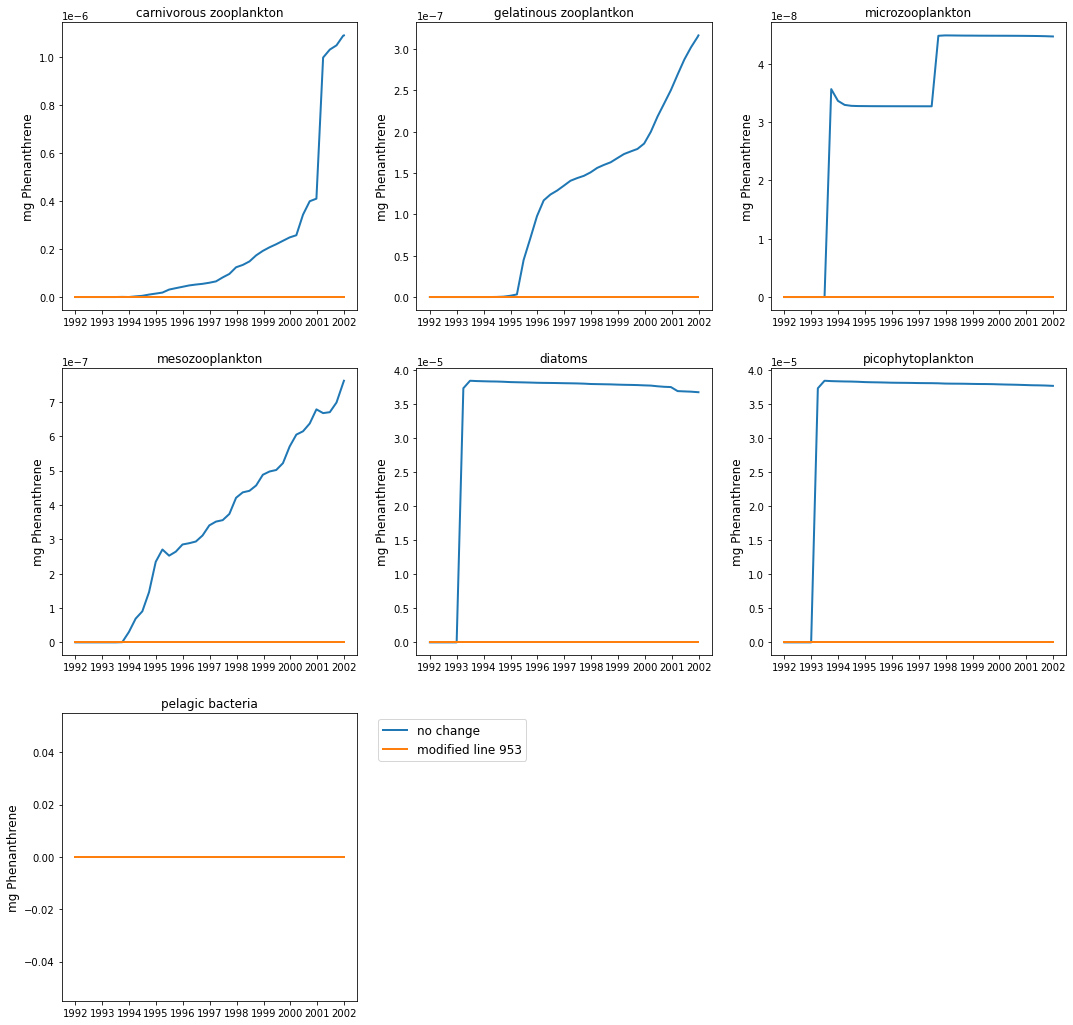

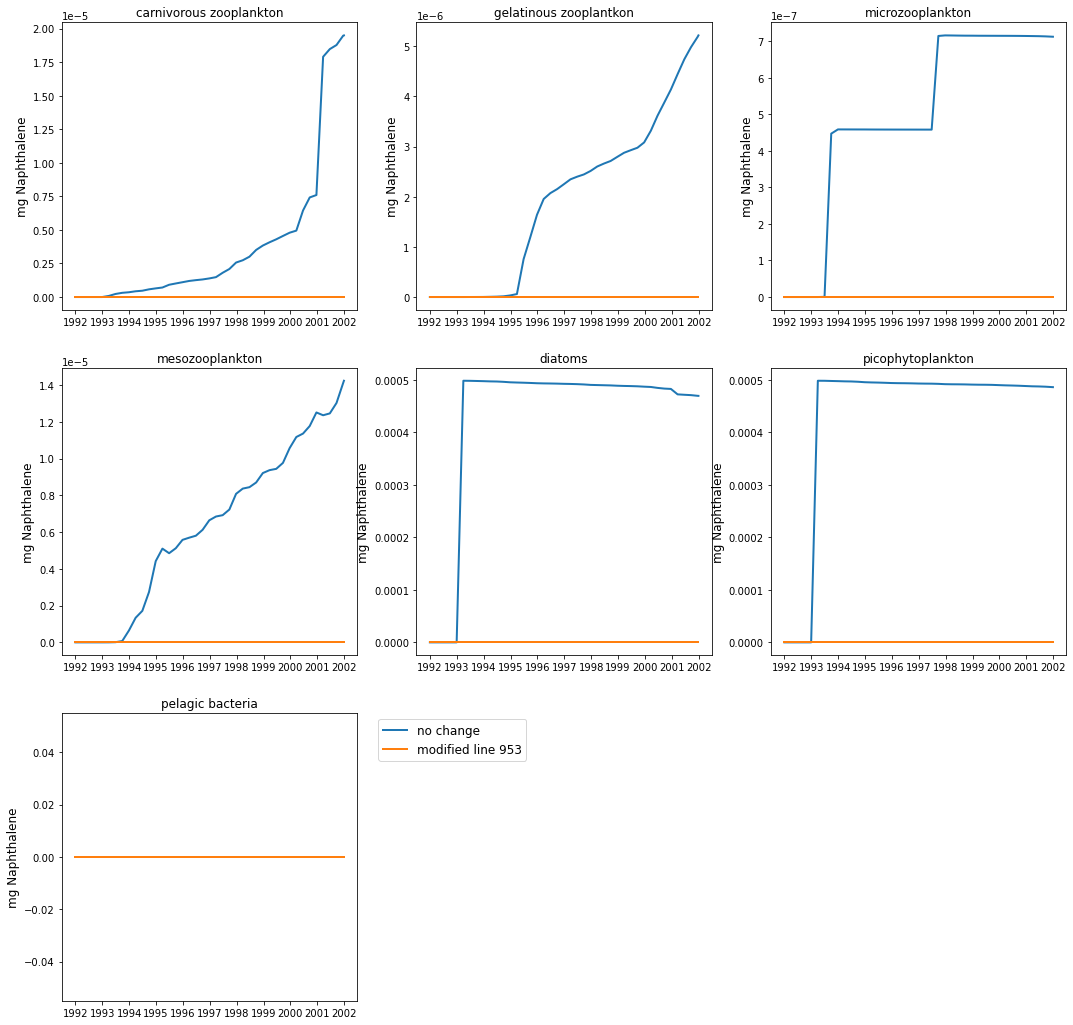

In [8]:
for pah in groups.pahs:
    tissue_concentration(groups.plankton, pah, scenarios)

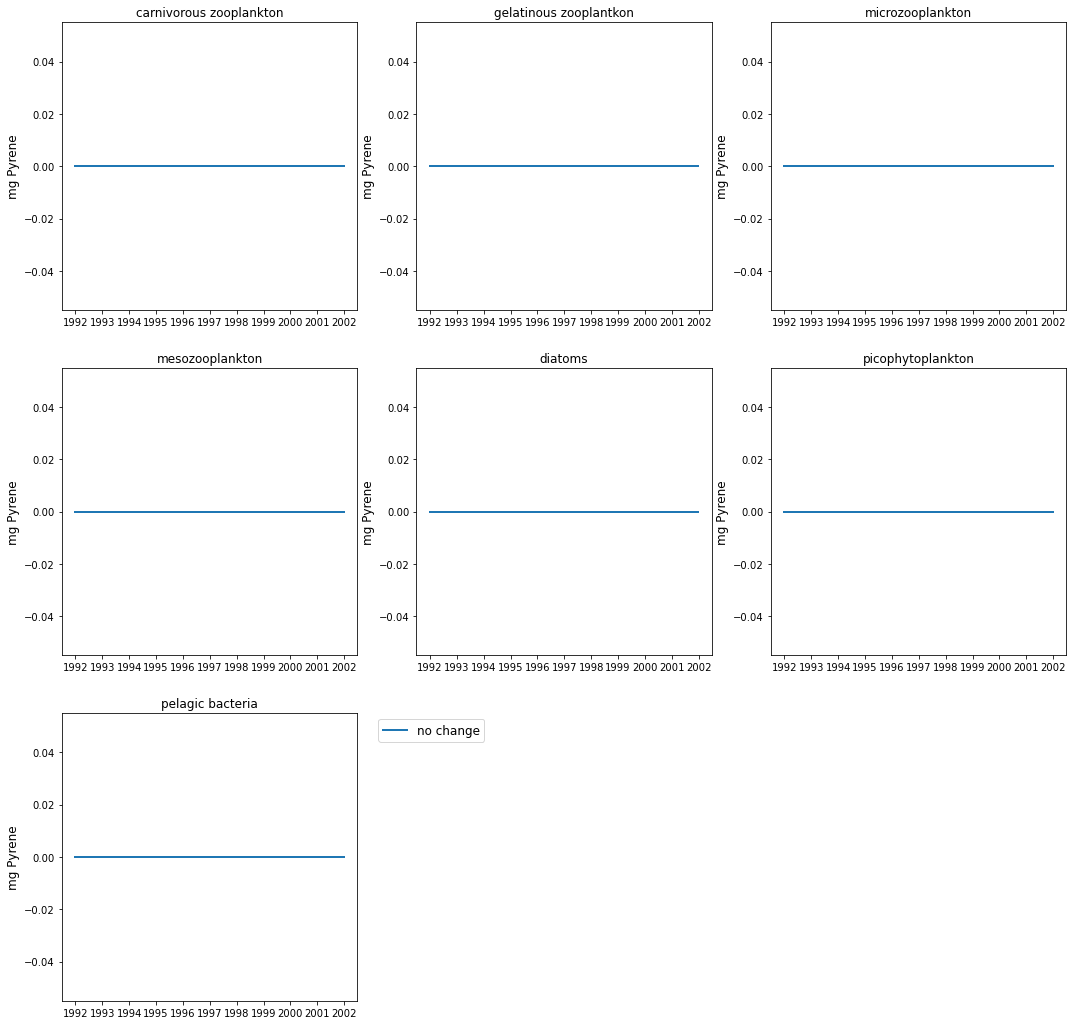

In [9]:
scen = [test4]
tissue_concentration(groups.plankton, "Pyrene", scen)

In [10]:
def plot_biomass(group, scens):
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2)
            pelagic_oiled = pelagic_oiled.sum(axis=1)
            ax.plot(time, pelagic_oiled, linewidth = 2)
        
        plt.ylabel('mg N', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

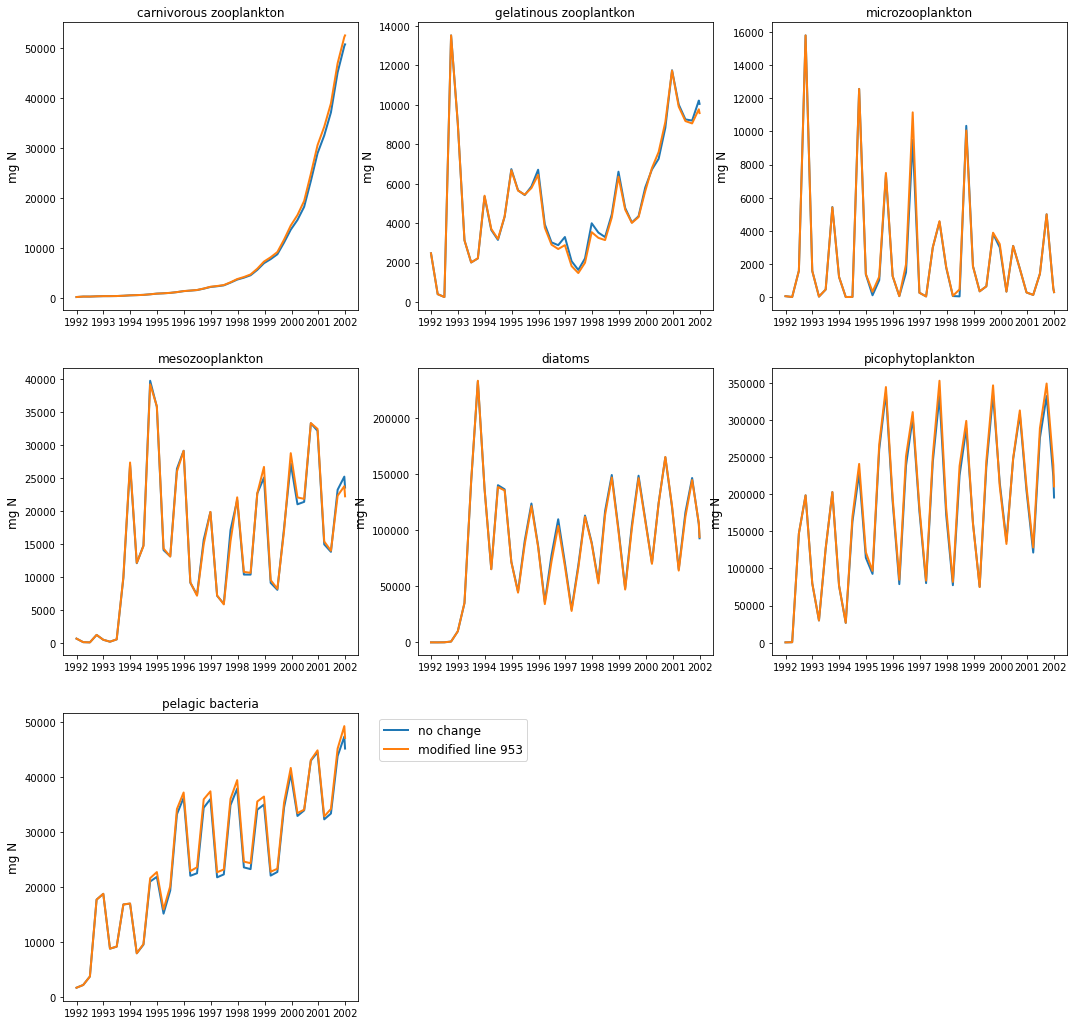

In [11]:
plot_biomass(groups.plankton, scenarios)

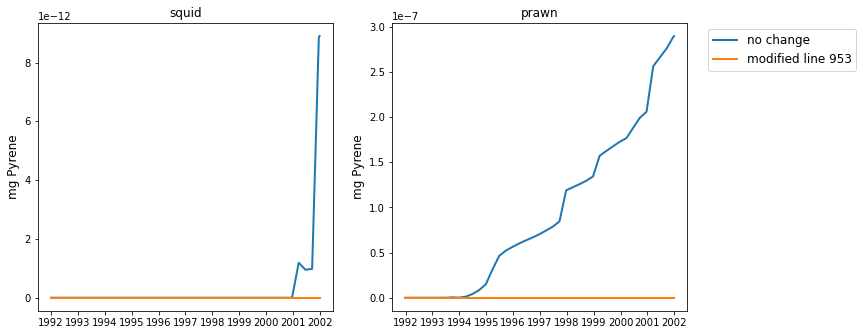

In [13]:
tissue_concentration(groups.pelagic_invertebrates, "Pyrene", scenarios)